# Temel Bilgiler: İlk Modelin Eğitilmesi

İlk makine öğrenmesi modelinizi eğiteceğiniz bu Colab dosyasına hoş geldiniz!

Bu dosyada basit tutulmaya çalışılmıştır ve temel kavramlar üzerine bir tanıtım niteliğindedir. Daha sonra karşımıza gelecek Colab dosyaları daha gelişmiş sorunları kapsayacak şekildedir.

Çözeceğimiz problem, Santigrattan -> Fahrenhayta dönüşümdür. Normalde formül şu şekildedir:
$$ f = c \times 1.8 + 32 $$

Elbette bu hesaplamayı doğrudan gerçekleştirebilecek bir Python fonksiyonu yazmak oldukça basit olurdu, ancak bu bir makine öğrenmesi olmazdı.

Böyle bir fonksiyon oluşturmak yerine, TensorFlow'a bazı santigrat (celcius) değerleri (değerler: 0, 8, 15, 22, 38) ve bunlara karşılık gelen fahrenhayt (fahrenheit) değerleri (değerler: 32, 46, 59, 72, 100) vereceğiz. Daha donrasında yukarıdaki formülü bulan bir modeli oluşturup, eğitmeye çalışacağız.

## Gereklili Kütüphanelerin İçeri Aktarılması

İlk olarak TensorFlow'u içerği aktaracağız. Burada, kullanım kolaylığı için bu kütüphaneyi `tf` sözdizimi ile çağıracağız. Bununla beraber hataları göstermesini istediğimizi belirtiyoruz.

Daha sonra [NumPy](http://www.numpy.org/) kütüphanesini `np` olarak içeri aktarıyoruz. Numpy, verilerimizi yüksek performanslı listeler olarak sunmamıza yardımcı olacaktır.


In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Eğitim Verilerinin Oluşturulması

Denetimli makine öğrenimi, bir dizi girdi ve çıktı verilen bir algoritma bulmakla ilgilidir. Bu Colab dosyasındaki görevimiz, santigrat cinsinden dereceler verildiğinde fahrenhayt cinsinden sıcaklığı verebilecek bir model oluşturmaktır. Modelimizi eğitmek için `celcius` ve `fahrenheit` adında iki liste oluşturacağız.


In [4]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype=float)
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype=float)

for i,c in enumerate(celsius):
  print("{} santigrat derece = {} fahrenhayt derecedir.".format(c, fahrenheit[i]))

-40.0 santigrat derece = -40.0 fahrenhayt derecedir.
-10.0 santigrat derece = 14.0 fahrenhayt derecedir.
0.0 santigrat derece = 32.0 fahrenhayt derecedir.
8.0 santigrat derece = 46.0 fahrenhayt derecedir.
15.0 santigrat derece = 59.0 fahrenhayt derecedir.
22.0 santigrat derece = 72.0 fahrenhayt derecedir.
38.0 santigrat derece = 100.0 fahrenhayt derecedir.


### Bazı Makine Öğrenimi Terimleri

- **Özellike (*Feature*)** : Modelimizin girdileridir. Bu görev için santigrat cinsinden dereceler.
- **Etiketler (*Labels*)** : Modelimizin tahmin ettiği çıktılardır. Bu görev için fahrenhayt cinsinden dereceler.
- **Örnek (*Example*)** : Eğitim sırasında kullanılan girdi-çıktı birlikteliğidir. Belirli bir indeksteki santigrat-fahrenhayt eşleşmesidir. Örneğin; (22, 72) girdi-çıktı çifti.

## Modelin Oluşturulması

Şimdi modelimizi oluşturma zamanı. Mümkün olan en basit modeli kullanacağız: Bir yoğun ağ (Dense Network). Sorun basit olduğu için, bu ağ tek bir nöron ile sadece tek bir katman (layer) oluşturmak yeterli olacaktır.

### Katman Oluşturulması

`tf.keras.layers.Dense` katmanı oluşturalım ve bu katmanı `l0` olarak çağıralım.

* `input_shape=[1]` — Bu parametre, katmana girdinin tek bir değer olduğunu belirtir. Yeni şekil, tek üyeli tek boyutlu bir dizidir. Bu ilk ve tek katman olduğundan, bu girdi şekli tüm modelin girdi şeklidir. Girdi olan bu tek değer, santigrat derecesini temsil eden `float` veri tipine sahip bir sayıdır.

* `units:1` — Bu parametre, katmandaki nöron sayısını belirtir. Nöron sayısı, katmanın problemi nasıl çözeceğini öğrenmek için kaç tane dahili değişkeni denemesi gerektiğini tanımlar. Bu son katman olduğu için, aynı zamanda modelin çıktısının (fahrenhayt derecesini temsil eden `float` veri tipinde tek bir sayı) boyutudur. 

Eğer çok katmanlı bir ağda çalışıyorsunuz, katmanın boyutu ve şeklinin bir sonraki katmanın `input_shape` parametresi ile eşleşmesi gerekir.

In [5]:
l0 = tf.keras.layers.Dense(units=1, input_shape=[1])

### Katmanların Model İle Birleştirilmesi

Katmanlar tanımlandıktan sonra, bir modelle birleştirilmesi gereklidir. Sıralı (Sequential) model tanımı, girdiden çıktıya kadar hesaplama sırasını belirten bir argüman olarak katmanların bir listesini bekler.

Bu modelimiz sadece `l0` adı verilen tek bir katmandan oluşmaktadır.

In [6]:
model = tf.keras.Sequential([l0])

**Not**

Aşağıdaki örnekteki gibi önceden tanımlanmamış, model oluştururken tanımlanan katmanlar görebilirsiniz :

```python
model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=1, input_shape=[1])
])
```

## Modelin, Kayıp ve Optimize Edici İşlevleriyle Derlenmesi

Eğitim başlamadan önce modelin derlenmesi gerekmektedir. Model derlenirlen aşağıdaki parametreleri bekler:

- **Kayıp Fonksiyonu (*Loss function*)** : Tahminlerin listenilen sonuçtan ne kadar uzakta olduğunu ölçmenin bir yoludur. (Ölçülen fark kayıp (loss) olarak adlandırılır.)

- **Optimize Edici Fonksiyon (*Optimizer function*)** : Kayıp değerinin azaltılması için dahili değerlerin ayarlanmasını sağlamanın yoludur.


In [7]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

Bu parametreler, eğitim sırasında her noktada kaybı hesaplamak ve sonra onu iyileştirmek için kullanılır. Aslında, bir modelin mevcut kaybını hesaplama ve ardından onu iyileştirme eylemi tam olarak eğitimin ne olduğudur.

Eğitim sırasında, modelin dahili değişkenlerindeki ayarlamaları hesaplamak için optimize edici işlevi kullanılır. Amaç, modeli (gerçekten bir matematik işlevi olan) santigratı fahrenhayta dönüştürmek için gerçek denklemi yansıtana kadar dahili değişkenleri ayarlamaktır.

TensorFlow, bu ayarlamayı gerçekleştirmek için sayısal analiz kullanır ve tüm bu karmaşık ayrıntılara burada  girmeyeceğiz. Bu parametreler hakkında bilinmesi yararlı olan şeyler şunlardır:

Burada kullanılan kayıp işlevi (ortalama kare hatası - [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)) ve optimize edici ([Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)), bunun gibi basit modeller için standarttır. Ancak bununla beraber birçok model mevcuttur.

Öğrenme oranı, (yukarıdaki kodda : `0.1` olarak atanmıştır.) kendi modellerimizi oluştururken düşünmemiz gereken optimize edici işlevin bir parçasıdır. Bu, modeldeki değerler ayarlanırken alınan adım boyutudur. Değer, çok küçükse modeli eğitmek için çok fazla iterasyon gerekecektir. Çok büyükse doğrulama düşecektir. İyi bir değer bulmak genellikle deneme yanılma gerektirmektedir, ancak aralık genellikle 0,001 (varsayılan değer) ile 0.1 aralığındadır.

## Modelin Eğitilmesi

Modelin eğitilmesi `fit` metodunun çağrılması ile gerçekleşir.

Eğitim sırasında model santigrat (celcius) değerlerini alır, mevcut dahil değişkenlerleri (ağırlıklar -weights- olarak da adlandırılır.) kullanarak bir hesaplama yapar ve fahrenhayta eşdeğer olması gereken değerleri verir. Ağırlıklar başlangıçta rastegele ayarlandığı için çıktı doğru değere yakın olmayacaktır. Gerçek çıktı ile istenilen çıktı arasında fark, kayıp işlevi kullanılarak hesaplanır ve optimize edici işlevini, ağırlıkları nasıl ayarlaması gerektiği konusunda yönlendirir.

Bu hesaplama `fit` yöntemi ile kontrol edilir. İlk argüman olarak girdiler ve ikinci argüman olarak istenilen çıktılar verilir. `epochs` bağımsız değişkeni, bu döngünün kaç kez çalıştırılacağını belirtir ve `verbose` yöntemin ne kadar çıktı üreteceğini denetler.

In [8]:
history = model.fit(celsius, fahrenheit, epochs=500, verbose=False)
print("Modelin eğitilmesi tamamlandı !")

Modelin eğitilmesi tamamlandı !


## Eğitim İstatistiklerinin Görüntülenmesi

`fit` yöntemi bir geçmiş (history) nesnesi döndürür. Bu nesneyi, her eğitim döneminden sonra modelimizin kaybının nasıl düştüğünü çizmek için kullanabiliriz. Yüksek bir kayıp, modelin öngördüğü fahrenhayt derecelerinin `fahrenheit` listesinde karşılık gelen değerden ne kadar uzak olduğu anlamına gelir.

Bunu görselleştirmek için [Matplotlib](https://matplotlib.org/) kütüphanesini kullanacağız. Görüntüyü incelerseniz il etapta modelimiz çok hızlı bir şekilde gelişiyor ve daha sonrasında doğru değerlere çok yakın olana kadar istikrarlı ve yavaş bir gelişme gösteriyor.

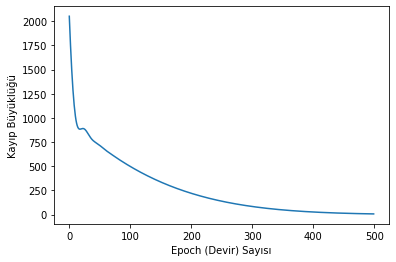

In [9]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch (Devir) Sayısı')
plt.ylabel("Kayıp Büyüklüğü")
plt.plot(history.history['loss'])

## Değerleri Tahmin Etmek İçin Modelin Kullanılması

Artık `celcius` ve `fahrenheit` arasındaki ilişkiyi öğrenmek için eğitilmiş bir modelimiz var. Modelin önceden görmediği (eğitim sırasında girdi olarak almadığı) santigrat derece değerleri için fahrenhayt derecelerini hesaplaması için `predict` (tahmin) yöntemini kullanabiliriz.

Tani modelin santigrat derece değeri 100 ise fahrenhayt değeri kaç olmalıdır?



In [10]:
print(model.predict([100.0]))

[[211.332]]


Doğru cevap $100 \times 1.8 + 32 = 212$ olmalıdır. Modelimiz oldukça başarılı bir tahminde bulundu.

### Özetle

* Dense (yoğun) katmanı ile bir model oluşturduk.
* 3500 (7 çift girdi, 500 yenileme -epochs- ile) örnek ile bu modeli eğittik.

Modelimiz, herhangi bir santigrat değeri için doğru fahrenhayt değerini döndürene kadar Dense katmanındaki değişkenleri (ağırlıkları) ayarladı. Unutmayın ki 100 santigrat dereği eğitim verimizin bir parçası değildi.

## Katman Ağırlıklarına Bakılması

Son olarak `Dense` katmanının iç değişkenlerini yazdıralım.


In [11]:
print("Katman değişkenlerimiz : {}".format(l0.get_weights()))

Katman değişkenlerimiz : [array([[1.8214457]], dtype=float32), array([29.187428], dtype=float32)]


İlk değişken ~1.8'e ve ikinci değikenimiz ise ~32 değerine oldukça yakındır. Bu değerler (1.8 ve 32) gerçek dönüşüm formülündeki değerlerdir.

Tek girişli ve tek çıkışlı tek bir nöron için dahili matematik, bir çizgi denklemiyle aynı görünür: $y = mx + b$ bu değerler bizim dönüşüm formülümüze uyarlanırsa : $f = 1.8c + 32$ ortaya çıkar.

Değişkenler değerlerimizin 1.8 ve 32 değerlerine bu denli yakınsaması oldukça iyidir.

Ek nöronlar, ek girdiler ve ek çıktılar ile formül daha karmaşık hale gelebilir ancak altında yatan temel fikir aynıdır.
